## Importing Libraries

In [10]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Datasets from mnist

In [22]:
(x_train, y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()

## Plot the first 10 examples from training set

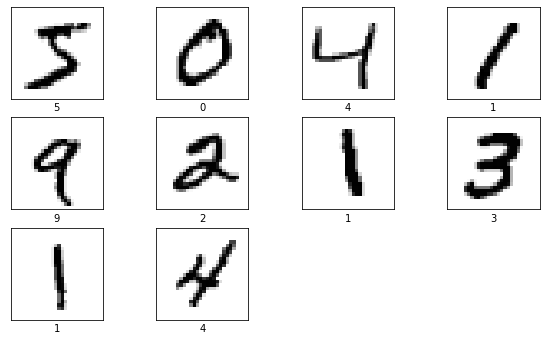

In [23]:
plt.figure(figsize = (10,20))

for i in range(0,10):
    plt.subplot(10,4,i+1)
    plt.imshow(x_train[i],cmap = "binary")
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

## Normalising the data

In [24]:
# size of data
print("x_train",x_train.shape)
print("y_train",y_train.shape)
print("x_test",x_test.shape)
print("y_test",y_test.shape)

# In the training set we have 60000 examples and in the test set we have 10000 examples
# Each example is an array of 28 x 28 which is the size of the image

# reshape the data to feature vector of size (28 x 28,1) for each example
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1]*x_test.shape[2]))

print(x_train.shape)
print(x_test.shape)

# normalisation
# each value in the array is between 0 to 255
# we divide each value by 255 to get a value between 0 and 1

x_train = x_train / 255
x_test = x_test / 255

x_train (60000, 28, 28)
y_train (60000,)
x_test (10000, 28, 28)
y_test (10000,)
(60000, 784)
(10000, 784)


## Creating a NN model 

In [26]:
# two hidden layers with 32 units each and tanh as activation function
# softmax is used for output layer
# 10 units are present in output layer
model  = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation = 'tanh' , input_shape =(784,)),
    tf.keras.layers.Dense(32, activation = 'tanh'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

## Training the model

In [27]:
_ = model.fit(
    x_train,y_train,
    validation_data = (x_test,y_test),
    epochs = 30, batch_size = 1024,
    verbose = 2
)

Epoch 1/30
59/59 - 1s - loss: 1.2402 - accuracy: 0.7051 - val_loss: 0.7095 - val_accuracy: 0.8598
Epoch 2/30
59/59 - 0s - loss: 0.5527 - accuracy: 0.8786 - val_loss: 0.4269 - val_accuracy: 0.9012
Epoch 3/30
59/59 - 0s - loss: 0.3804 - accuracy: 0.9046 - val_loss: 0.3313 - val_accuracy: 0.9131
Epoch 4/30
59/59 - 0s - loss: 0.3092 - accuracy: 0.9182 - val_loss: 0.2854 - val_accuracy: 0.9212
Epoch 5/30
59/59 - 0s - loss: 0.2687 - accuracy: 0.9271 - val_loss: 0.2537 - val_accuracy: 0.9282
Epoch 6/30
59/59 - 0s - loss: 0.2402 - accuracy: 0.9347 - val_loss: 0.2337 - val_accuracy: 0.9319
Epoch 7/30
59/59 - 0s - loss: 0.2195 - accuracy: 0.9392 - val_loss: 0.2165 - val_accuracy: 0.9369
Epoch 8/30
59/59 - 0s - loss: 0.2022 - accuracy: 0.9437 - val_loss: 0.2016 - val_accuracy: 0.9406
Epoch 9/30
59/59 - 0s - loss: 0.1870 - accuracy: 0.9479 - val_loss: 0.1878 - val_accuracy: 0.9438
Epoch 10/30
59/59 - 0s - loss: 0.1752 - accuracy: 0.9509 - val_loss: 0.1782 - val_accuracy: 0.9465
Epoch 11/30
59/59 -

## Save the NN model

In [29]:
model.save('model.h5')

## ML server

In [32]:
%%writefile ml_server.py

# creating a basic flask server

import json
import tensorflow as tf
import numpy as np
import random

from flask import Flask, request

app = Flask(__name__)

model = tf.keras.models.load_model('model.h5')

# feature model will take the input same as 'model' but give the output of all layers
model = tf.keras.models.load_model('model.h5')
feature_model = tf.keras.models.Model(
    model.inputs,
    [layer.output for layer in model.layers]
)

_ , (x_test, _) = tf.keras.datasets.mnist.load_data()
x_test = x_test/ 255

def get_prediction():
    index = np.random.choice(x_test.shape[0])
    image = x_test[index, :,:]
    image_arr = np.reshape(image,(1,x_test.shape[1]*x_test.shape[2]))
    return feature_model.predict((image_arr)), image


@app.route('/', methods = ['GET','POST'])

def index():
    if request.method == 'POST':
        preds, image = get_prediction()
        final_preds = [p.tolist() for p in preds]
        return json.dumps({
            'prediction': final_preds,
            'image': image.tolist()
        })
    return "Welcome to ML server"

if __name__ == '__main__':
    app.run()



Overwriting ml_server.py


## Streamlit web application

In [33]:
%%writefile app.py

import streamlit as st
import json
import requests
import matplotlib.pyplot as plt
import numpy as np

# use streamlit run app.py to run the app

URI = 'http://127.0.0.1:5000/'

st.title('Neural Network Visualiser')
st.sidebar.markdown("## Input Image")

if st.button('Get random prediction'):
    response = requests.post(URI, data={})
    response = json.loads(response.text)
    preds = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image,(28,28))
    
    st.sidebar.image(image,width = 150)
    
    for layer, p in enumerate(preds):
        numbers = np.squeeze(np.array(p))
        plt.figure(figsize = (32,4))
        
        # output layer
        if layer == 2:
            row = 1
            col = 10
        
        # hidden layers
        else: 
            row = 2
            col = 16
        
        for i, number in enumerate(numbers):
            plt.subplot(row,col, i+1)
            plt.imshow(number * np.ones((8,8,3)).astype('float32'))
            plt.xticks([])
            plt.yticks([])
            
            if layer == 2:
                plt.xlabel(str(i), fontsize  = 40)
        
        plt.subplots_adjust(wspace = 0.05, hspace = 0.05)
        plt.tight_layout()
        st.text('Layer {}'.format(layer+1))
        st.pyplot()

Overwriting app.py
